In [23]:
# lstm autoencoder predict sequence
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
# Reference: https://scikit-learn.org/stable/modules/clustering.html#clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import datasets, metrics
import seaborn as sns

G Drive connect for data

In [2]:
gdrive_project_pathname = '/My Drive/w210'  #@param {type: "string"}

In [22]:
import os.path
from google.colab import drive

# Mount the current user's Google Drive
GOOGLE_DRIVE_MOUNT_POINT = "/content/drive"
print("Mounting Google Drive beneath %s" % GOOGLE_DRIVE_MOUNT_POINT)
drive.mount(GOOGLE_DRIVE_MOUNT_POINT, force_remount = True)

# Build the pathname to the project's folder residing beneath the current user's Google Drive
if not gdrive_project_pathname.startswith("/"):
  gdrive_project_pathname = "/" + gdrive_project_pathname
abs_project_pathname = GOOGLE_DRIVE_MOUNT_POINT + gdrive_project_pathname
print("Project folder: %s" % gdrive_project_pathname)


Mounting Google Drive beneath /content/drive
Mounted at /content/drive
Project folder: /My Drive/w210


Define a function to convert Pandas DataFrame outputted from `satellite_imagery(..., plot_option='no')` to numpy array

In [24]:
def time_series_prep(in_df, stat_option):
    col_lst = list(in_df.columns)
    col_lst_select = [i for i in col_lst if stat_option in i]
    # Rearrange the order the columns based on YYYYMM
    col_lst_select.sort()
    out_df = in_df[col_lst_select]
    return out_df.to_numpy()

Define a function to perform K-means classification

In [25]:
def kmeans(in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    km = KMeans(n_clusters=n_classes)
    km.fit(in_arr)
    km.predict(in_arr)
    labels = km.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(in_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform Agglomerative Clustering

In [26]:
def agglomerative(in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    aggClus = AgglomerativeClustering(n_clusters=n_classes).fit(in_arr)
    labels = aggClus.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(in_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform LSTM encode and decode actions

In [27]:
def LSTM_autoencoder(in_arr, n_features, n_epochs):
    # Reference: https://machinelearningmastery.com/lstm-autoencoders/
    # reshape input into [samples, timesteps, features] if needed
    sequence = in_arr.reshape((in_arr.shape[0], in_arr.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_features, activation='relu', input_shape=(in_arr.shape[1],1)))
    model.add(RepeatVector(in_arr.shape[1]))
    model.add(LSTM(n_features, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    # fit model
    history = model.fit(sequence, sequence, validation_split = 0.5, epochs=n_epochs)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # plt.title('model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    # connect the encoder LSTM as the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[0].output)
    # get the feature vector for the input sequence
    yhat = model.predict(sequence)
    return yhat

In [28]:
def LSTM_autoencoder_plus(in_arr, n_features, n_epochs):
    check = 0
    while (check == 0):
        yhat = LSTM_autoencoder(in_arr, n_features, n_epochs)
        nrows = in_arr.shape[0]
        check = 1
        for col in range(n_features):
            n_zeros = (yhat[:,col]==0).sum()
            print('Column {} has {:.2%} of zeros'.format(col, n_zeros/nrows))
            if n_zeros == nrows:
                check = 0
        if check == 0:
            print('At least 1 column is all zeros. Refit -------------------------------------------')
    return yhat

Read in data output from `GEE_SatelliteImagery_EDA.ipynb`

In [11]:
ID_df = pd.read_csv(abs_project_pathname + '/time_series_ID_scale10.csv')
ID_df.head()

,Unnamed: 0,lat,lon,201805_NDVI,201805_SAVI,201805_EVI,201812_NDVI,201812_SAVI,201812_EVI,201801_NDVI,201801_SAVI,201801_EVI,201811_NDVI,201811_SAVI,201811_EVI,201804_NDVI,201804_SAVI,201804_EVI,201802_NDVI,201802_SAVI,201802_EVI,201806_NDVI,201806_SAVI,201806_EVI,201810_NDVI,201810_SAVI,201810_EVI,201808_NDVI,201808_SAVI,201808_EVI,201809_NDVI,201809_SAVI,201809_EVI,201807_NDVI,201807_SAVI,201807_EVI
0,0,43.768661,-116.739350,0.176445,0.264642,0.561106,0.110320,0.165463,1.181932,-0.014664,-0.021996,0.471294,0.209575,0.314338,0.485266,0.142669,0.213980,0.487173,0.102280,0.153403,0.547313,0.407697,0.611480,2.686295,0.372298,0.558374,2.157721,0.664816,0.997105,-7.735765,0.714488,1.071605,12.477374,0.653170,0.979619,-3.501948
1,1,43.768661,-116.739260,0.172219,0.258304,0.530505,0.100356,0.150518,1.080581,-0.018005,-0.027007,0.612316,0.197279,0.295893,0.502582,0.137631,0.206424,0.449860,0.112571,0.168837,0.596581,0.400778,0.601102,2.707461,0.378952,0.568354,2.201001,0.665370,0.997933,-18.304278,0.692162,1.038121,11.431691,0.662800,0.994062,-2.991320
2,2,43.768661,-116.739170,0.166754,0.250107,0.514179,0.088017,0.132011,1.120817,-0.022291,-0.033435,0.859038,0.197930,0.296868,0.544905,0.140232,0.210325,0.457048,0.113164,0.169726,0.696933,0.388256,0.582321,2.303018,0.377533,0.566227,2.114196,0.660143,0.990098,-19.423686,0.702319,1.053354,10.833210,0.647084,0.970498,-2.342274
3,3,43.768661,-116.739081,0.165201,0.247778,0.498756,0.108057,0.162068,1.569025,-0.022249,-0.033372,0.517193,0.210857,0.316258,0.542539,0.131190,0.196764,0.416644,0.101609,0.152396,0.519340,0.381168,0.571690,2.409745,0.362021,0.542963,1.722504,0.658597,0.987778,-6.962047,0.704748,1.056998,12.353717,0.615602,0.923282,-4.086213
4,4,43.768661,-116.738991,0.165201,0.247778,0.498756,0.108057,0.162068,1.569025,-0.022249,-0.033372,0.517193,0.210857,0.316258,0.542539,0.131190,0.196764,0.416644,0.101609,0.152396,0.519340,0.381168,0.571690,2.409745,0.362021,0.542963,1.722504,0.658597,0.987778,-6.962047,0.704748,1.056998,12.353717,0.615602,0.923282,-4.086213


In [12]:
ID_arr = time_series_prep(in_df=ID_df, stat_option='SAVI')

Model 1: K-Means

Silhouette Coefficient is:  0.8010586216734812


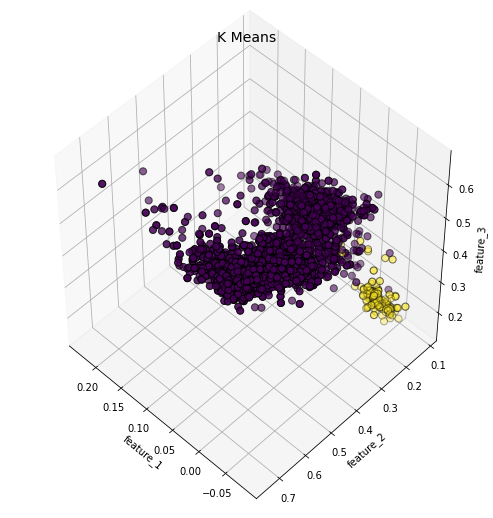

In [13]:
ID_label = kmeans(in_arr=ID_arr, n_classes=2)

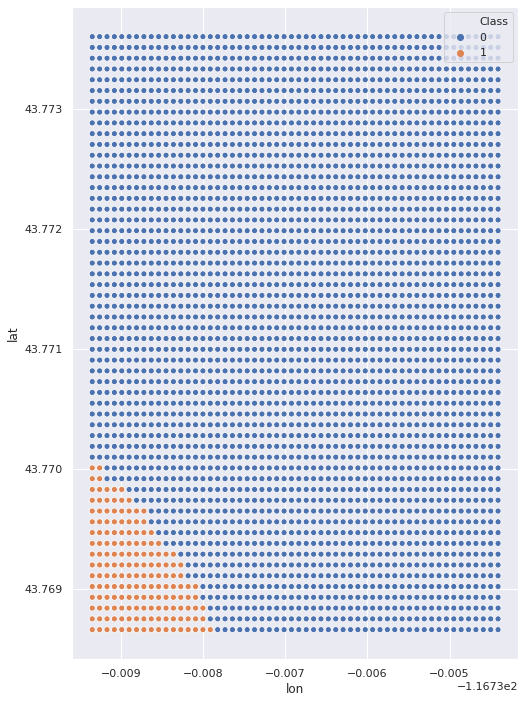

In [14]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 2: Agglomerative Clustering

Silhouette Coefficient is:  0.7969615190082203


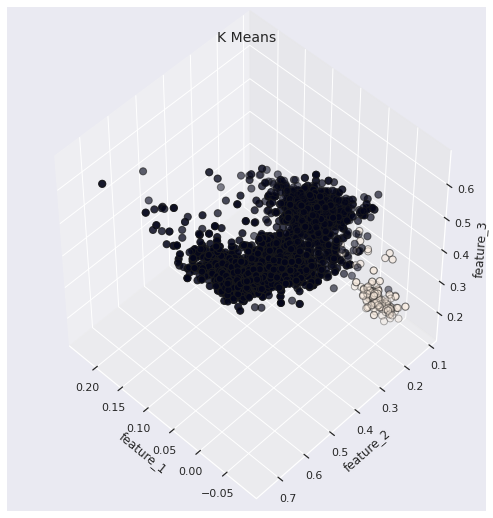

In [15]:
ID_label = agglomerative(in_arr=ID_arr, n_classes=2)

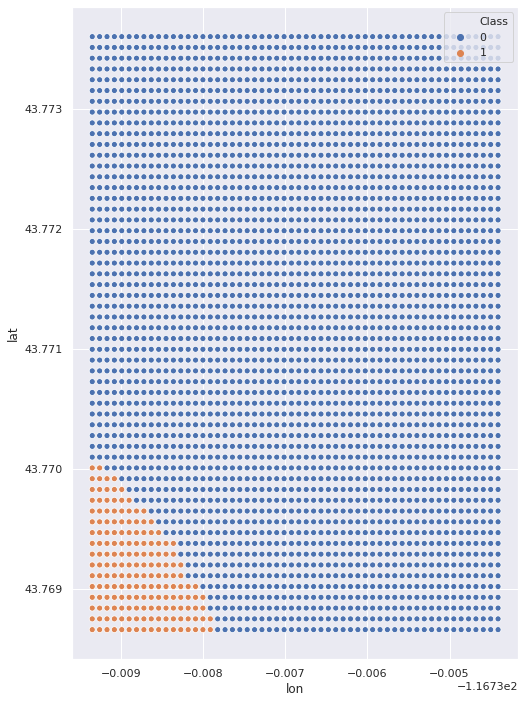

In [16]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 3: LSTM Autoencoder + K-Means

Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 6s 4ms/step - loss: 0.2901 - val_loss: 0.2344
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2503 - val_loss: 0.1962
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2132 - val_loss: 0.1609
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1792 - val_loss: 0.1291
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1503 - val_loss: 0.1081
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1333 - val_loss: 0.1052
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1287 - val_loss: 0.1061
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1277 - val_loss: 0.1070
Epoch 9/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1275 - val_loss: 0.1075
Epoch 10/50
1568/1568 [===========

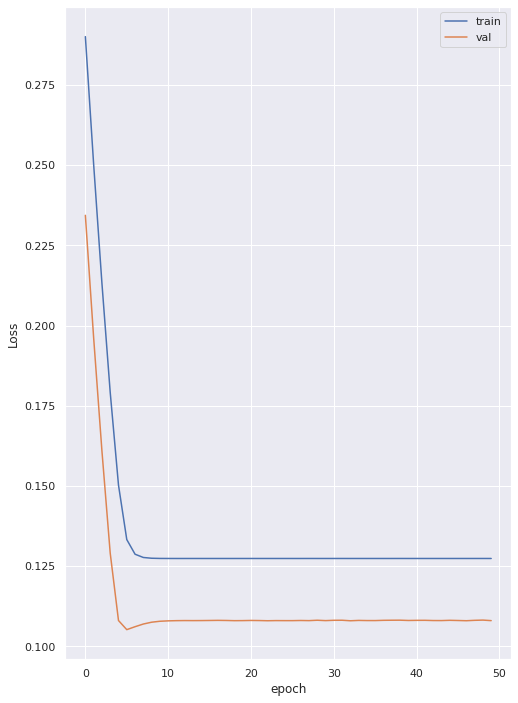

Column 0 has 100.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 45.98% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 3ms/step - loss: 0.2869 - val_loss: 0.2055
Epoch 2/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.2012 - val_loss: 0.1276
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1349 - val_loss: 0.1109
Epoch 4/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.1272 - val_loss: 0.1093
Epoch 5/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.1268 - val_loss: 0.1089
Epoch 6/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.1264 - val_loss: 0.1085
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1260 - val_loss: 0.1080
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/step -

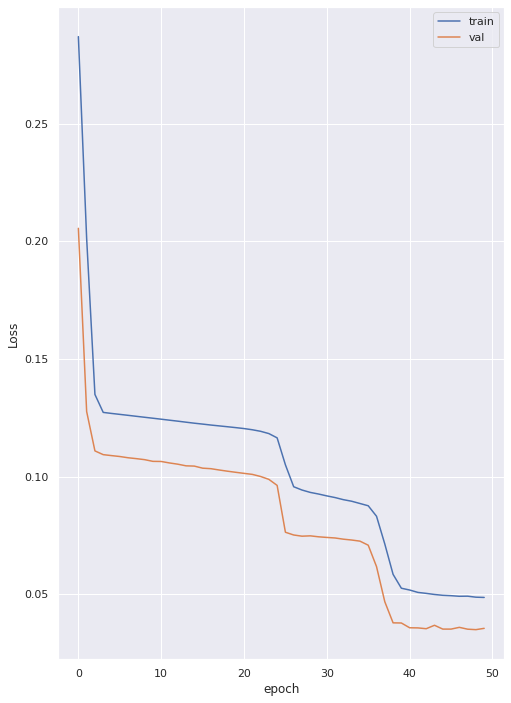

Column 0 has 0.00% of zeros
Column 1 has 3.19% of zeros
Column 2 has 0.00% of zeros


In [17]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

Silhouette Coefficient is:  0.46265715


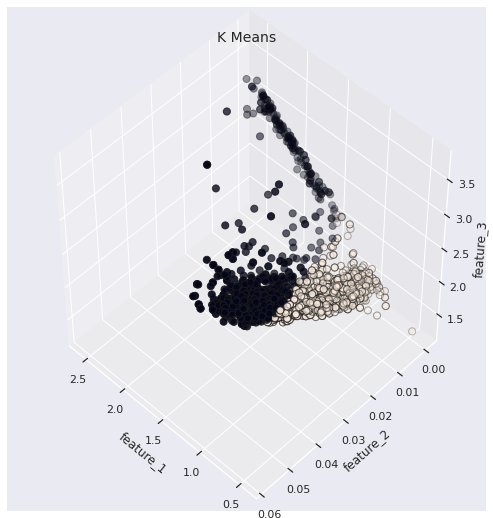

In [18]:
ID_label = kmeans(in_arr=ID_feature, n_classes=2)

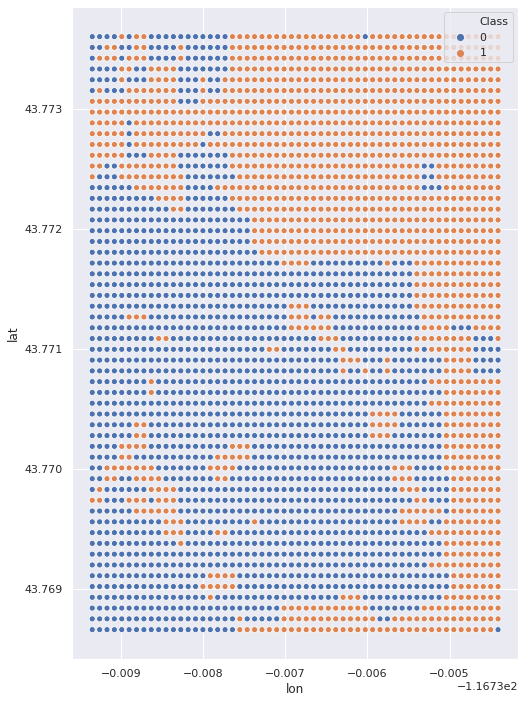

In [19]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

===========================================================================================================

In [29]:
ID_df = pd.read_csv(abs_project_pathname + '/time_series_India_scale10.csv')
ID_arr = time_series_prep(in_df=ID_df, stat_option='SAVI')

Silhouette Coefficient is:  0.3240289627880457


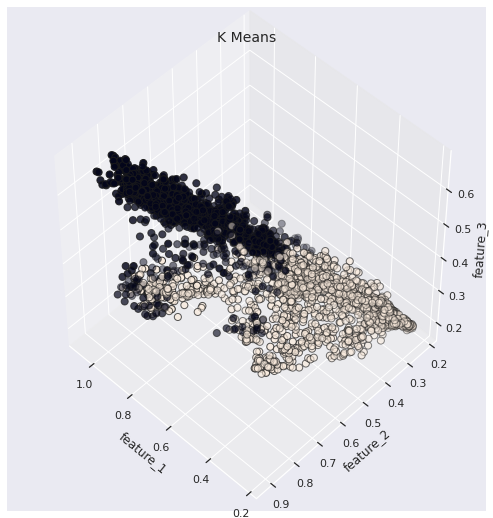

In [30]:
ID_label = kmeans(in_arr=ID_arr, n_classes=2)

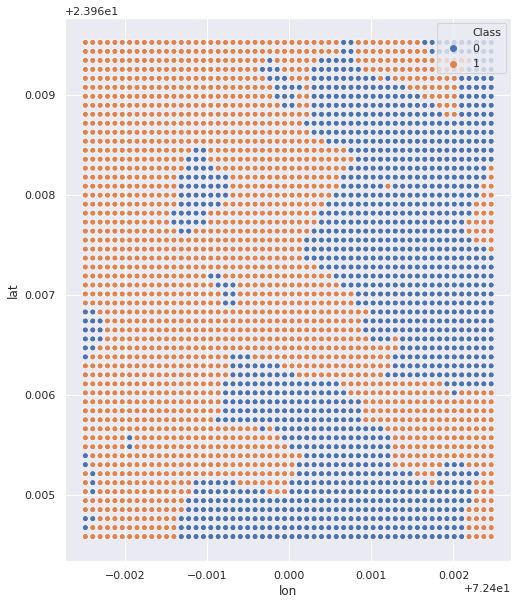

In [31]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,10)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Silhouette Coefficient is:  0.3066541494075668


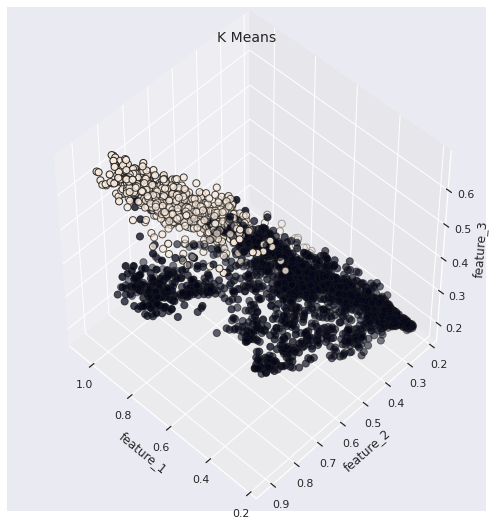

In [32]:
ID_label = agglomerative(in_arr=ID_arr, n_classes=2)

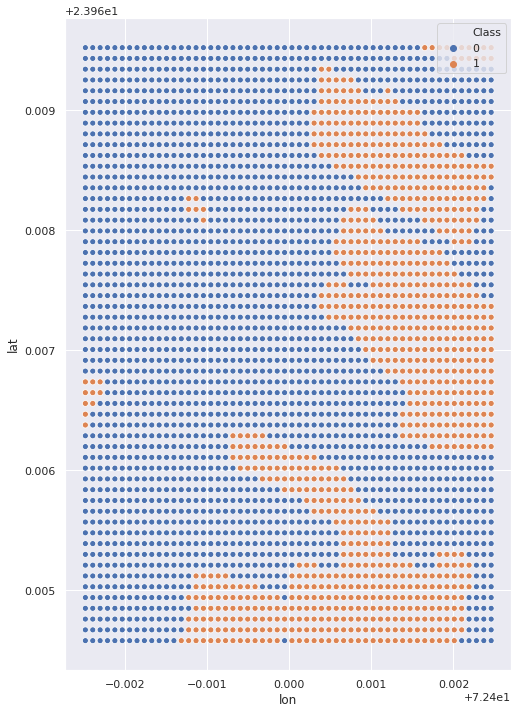

In [33]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 3ms/step - loss: 0.4083 - val_loss: 0.3471
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.3311 - val_loss: 0.2567
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2397 - val_loss: 0.1959
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2089 - val_loss: 0.1971
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2075 - val_loss: 0.1962
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2063 - val_loss: 0.1961
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2050 - val_loss: 0.1939
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2036 - val_loss: 0.1937
Epoch 9/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2017 - val_loss: 0.1936
Epoch 10/50
1568/1568 [===========

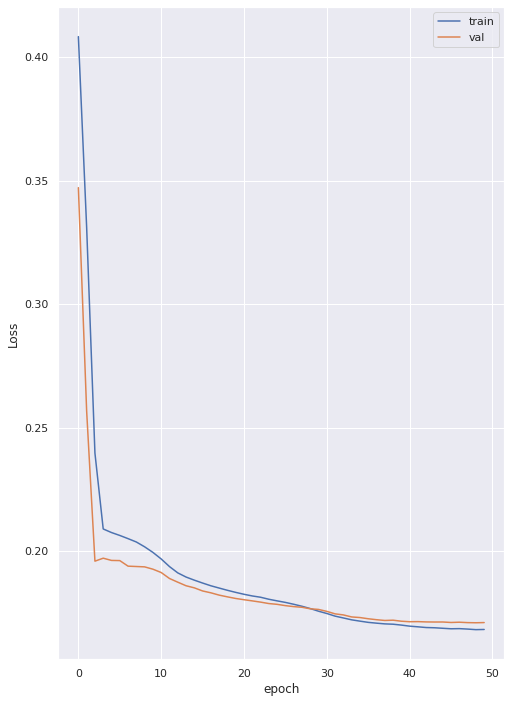

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.4159 - val_loss: 0.3643
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.3666 - val_loss: 0.3149
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.3174 - val_loss: 0.2663
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2722 - val_loss: 0.2286
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2408 - val_loss: 0.2060
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2225 - val_loss: 0.1945
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2120 - val_loss: 0.1882
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/step - 

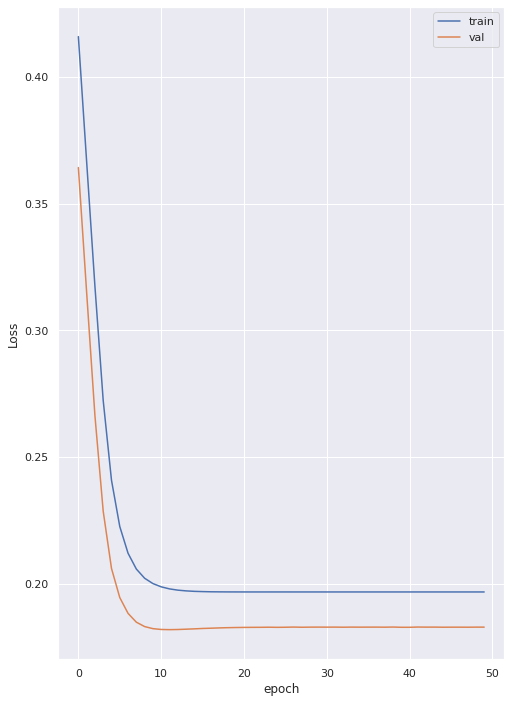

Column 0 has 100.00% of zeros
Column 1 has 100.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.2856 - val_loss: 0.2067
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2136 - val_loss: 0.2051
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2110 - val_loss: 0.2029
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2086 - val_loss: 0.1998
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2041 - val_loss: 0.1960
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1999 - val_loss: 0.1926
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1969 - val_loss: 0.1897
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/ste

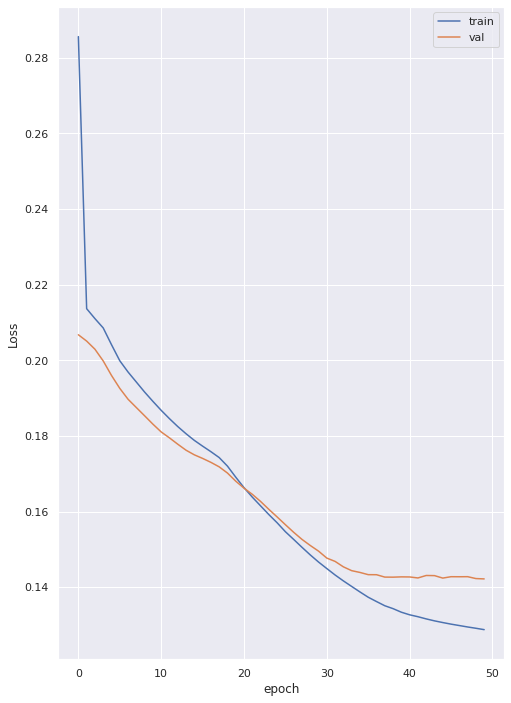

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 0.00% of zeros


In [34]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

Silhouette Coefficient is:  0.62599385


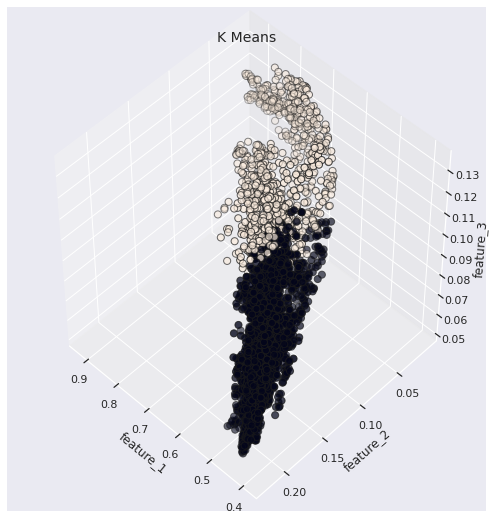

In [35]:
ID_label = kmeans(in_arr=ID_feature, n_classes=2)

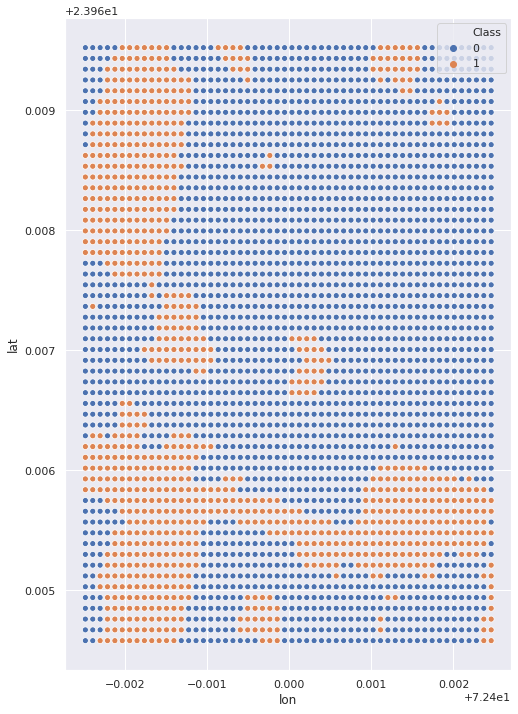

In [36]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')